In [132]:
import torch
import pandas as pd
import numpy as np
import torch.utils
import torchvision.transforms
from torch import nn
import matplotlib.pyplot as plt
%matplotlib inline

torch.set_printoptions(threshold=1000)

In [32]:
#Loading house prices training and test dataset
hptrain = pd.read_csv("Datasets/hptrain.csv",index_col=0)
hptest = pd.read_csv("Datasets/hptest.csv",index_col=0)

In [33]:
#Transforming data into tensor data format from pandas' dataframe
X_ols_train = torch.tensor(hptrain[['LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea', 'TotalBsmtSF']].values,requires_grad=True,dtype=torch.float32)
X_ols_train = nn.functional.normalize(X_ols_train)
Y_ols_train = torch.tensor(hptrain[['SalePrice']].values,requires_grad=True,dtype=torch.float32)


#Splitting data into iterable batches
olstensor = torch.utils.data.TensorDataset(X_ols_train,Y_ols_train)
olsdataloader = torch.utils.data.DataLoader(olstensor, batch_size=20,shuffle=True)

In [34]:
#Specifying the paramenters of our model (ols - ordinary least squares i.e. linear regression)
olsnet = nn.Sequential(nn.Linear(X_ols_train.size()[1],Y_ols_train.size()[1]))
olsnet[0].weight.data.normal_(0, 0.1)
olsnet[0].bias.data.normal_(0, 0.1)
olsloss = nn.MSELoss()
olstrainer = torch.optim.SGD(olsnet.parameters(),lr=0.0001)

In [35]:
num_epochs = 5
olsnet.train()
for epoch in range(num_epochs):
    print('-------------------')
    print(f'{epoch+1}th epoch')
    print('===================')
    olstrainer.zero_grad()
    X, Y = next(iter(olsdataloader))
    output = olsnet(X)

    l = olsloss(output,Y)
    print(f'Loss ols:{l}')


    l.backward(retain_graph=True)

    olstrainer.step()
    print('Coefficients: ',olsnet[0].weight.data)


-------------------
1th epoch
Loss ols:29889024000.0
Coefficients:  tensor([[3.3032e+01, 1.1173e-02, 1.6113e-01, 3.2019e-01, 4.7043e+00]])
-------------------
2th epoch
Loss ols:38795599872.0
Coefficients:  tensor([[6.9708e+01, 4.3485e-02, 1.8754e-01, 5.9882e-01, 9.7254e+00]])
-------------------
3th epoch
Loss ols:30773739520.0
Coefficients:  tensor([[1.0256e+02, 6.8166e-02, 2.1024e-01, 9.3925e-01, 1.3945e+01]])
-------------------
4th epoch
Loss ols:58688897024.0
Coefficients:  tensor([[1.4750e+02, 9.6646e-02, 2.3292e-01, 1.5081e+00, 1.9511e+01]])
-------------------
5th epoch
Loss ols:44163383296.0
Coefficients:  tensor([[1.8386e+02, 1.2079e-01, 2.5332e-01, 1.8477e+00, 2.4070e+01]])


In [36]:
'''--------------------------------------------------------'''

'--------------------------------------------------------'

In [183]:
#Creating a class for displaying the results
class Evaluation_Cross_Entropy:
    """For evaluating the accuracy of image recognition neural networks"""
    def __init__(self,net,img = None,label = None):
        #History of saved error rates, used for in-sample error evaluation during neural network training
        self.hist = []
        self.loss = []
        self.net = net
        self.img = img
        self.label = label

    def prob(self):
        """Returns probabilities for each label"""
        output = self.net(self.img).double()
        exp = torch.exp(output)
        sum = torch.sum(exp,dim=-1)
        probabilities = exp / sum.unsqueeze(1)
        return probabilities

    def pred(self):
        """Returns the labels our model predicted for each image"""
        pred = torch.argmax(self.prob(),dim=1)
        return pred

    def cert(self):
        """(certainty) Returns the probabilities of the chosen label for each image"""
        return torch.amax(self.prob(),dim=1)

    def error(self):
        """Returns missclassificaiton eror rate"""
        return torch.sum(self.pred() != self.label)/len(self.label)

    def missclass(self):
        boo = self.label != self.pred()
        print(torch.sum(boo))
        temp = boo.nonzero()
        temp2 = torch.reshape(temp,(1,temp.size(dim=0))).data[0]
        temp3 = torch.index_select(self.label,0,temp2)
        unique_miss, count_miss = torch.unique(temp3,sorted=True,return_counts=True)
        unique_label = torch.unique(self.label,sorted=True)
        count_label = torch.zeros(1,len(unique_label)).data[0]
        j = 0
        for i in range(len(unique_label)):
            if unique_label[i] == unique_miss[j]:
                count_label[i] = count_miss[j]
                j +=1

        return count_miss/torch.sum(boo)


    def add(self,img,label,loss = False):
        """Appends an error rate (and loss if not False) to the history)"""
        self.img = img
        self.label = label
        self.hist.append(self.error())
        self.loss.append(loss)

    def __getitem__(self,idx,idy):
        if idx == 0:
            return self.hist[idy]
        if idx ==1:
            return self.loss[idy]

    def plot_error(self):
        """Plots the in-sample error from training history"""

        plt.plot(self.hist)
        plt.ylabel('In-sample error')
        plt.xlabel('Epoch')
        plt.show()

    def plot_loss(self):
        """Plots the loss from training history"""

        plt.plot(self.loss)
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.show()


In [140]:
#Creating an automatic trainer to be used with sequential linear classes
class Gradient_Img_Trainer:
    """Automatic trainer for linear classifiers embedded through a sequential class"""
    def __init__(self,net,train_iter,loss,trainer,test_iter = None,scheduler = None):
        self.net = net
        self.train_iter = train_iter
        self.loss = loss
        self.trainer = trainer
        self.test_iter = test_iter
        self.eval = None
        self.scheduler = scheduler

    def normal_init(self, std = 0.1):
        """Used for initializing the weights of the nn from a normal distribution"""
        def init_normal(m):
            if type(m) == nn.Linear:
                nn.init.normal_(m.weight, std=std)

        self.net.apply(init_normal)

    def xavier_uniform(self):
        """Used for initializing the weights of the nn according to a xavier method from a uniform"""
        def xavier(m):
            if type(m)== nn.Linear:
                nn.init.xavier_uniform_(m.weight)

        self.net.apply(xavier)

    def xavier_normal(self):
        """Used for initializing the weights of the nn according to a xavier method from a normal"""
        def xavier(m):
            if type(m)== nn.Linear:
                nn.init.xavier_normal_(m.weight)

        self.net.apply(xavier)


    def Train(self, num_epochs, print_loss = True, print_error = True):
        """Used for training the neural network
                :param print_loss: - print loss for each epoch
                :param print_error: - print error for each epoch
                :param graph: - graph in-sample error at the end of training"""
        self.net.train()
        eval = Evaluation_Cross_Entropy(net=self.net)
        for epoch in range(num_epochs):
            if print_loss is True or print_error is True:
                print('-------------------')
                print(f'{epoch+1}th epoch')
                print('===================')

            self.net.zero_grad()

            #Trainig the model
            img, label = next(iter(self.train_iter))
            output = self.net(img).double()
            l = self.loss(output,label)
            l.mean().backward()
            self.trainer.step()

            eval.add(img,label,l.sum().item())

            #Adjusting the learning rate
            if self.scheduler is not None:
                self.scheduler.step()

            if print_loss is True:
                print("Loss:",l.sum().item())

            if print_error is True:
                print("In-sample error:",eval.error())


        self.eval = eval

    def Test(self,test_iter=None):
        self.net.eval()
        if self.test_iter is None:
            self.test_iter = test_iter
        img, label = next(iter(self.test_iter))
        result = Evaluation_Cross_Entropy(net=self.net, img=img, label=label)
        print("Out-of-sample error:",result.error())
        self.result = result

In [6]:
#Loading in complex MNIST train and test datasets while transforming them to 28x28
trans = [torchvision.transforms.ToTensor()]
trans.insert(0, torchvision.transforms.Resize(28))
trans = torchvision.transforms.Compose(trans)


mnist_train = torchvision.datasets.FashionMNIST(
    root="../PyTorch_Basic/Datasets",train = True, transform=trans, download= True)
mnist_test = torchvision.datasets.FashionMNIST(
    root="../PyTorch_Basic/Datasets",train = False, transform=trans, download= True)

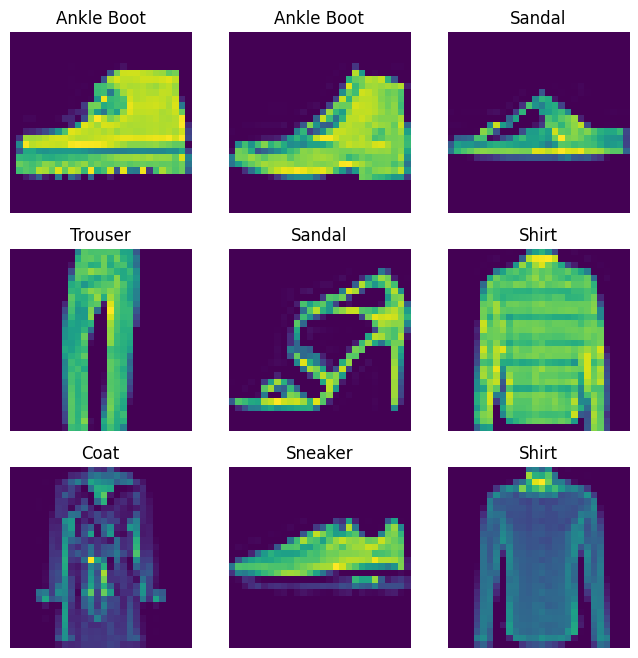

In [5]:
#Visualizing 9 random examples
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(mnist_train), size=(1,)).item()
    imge, labele = mnist_train[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[labele])
    plt.axis("off")
    plt.imshow(imge.squeeze())
plt.show()

In [10]:
#Splitting our data into batch sizes
mnist_batch_size = 256

mnist_train_iter = torch.utils.data.DataLoader(mnist_train,mnist_batch_size,shuffle=True,num_workers=4)
mnist_test_iter = torch.utils.data.DataLoader(mnist_test,mnist_test.__len__(),shuffle=False,num_workers=4)

In [192]:
#Creating the model and initializing the weights (logit - logistic regression)
logit_net = nn.Sequential(nn.Flatten(),nn.Linear(784,10))

#Initializing weights
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

logit_net.apply(init_weights)

#Specifying cross entropy loss
logit_loss = nn.CrossEntropyLoss(reduction='none')

#Specifying Stochastic Gradient Descent trainer
logit_trainer = torch.optim.SGD(logit_net.parameters(), lr=0.1)

In [193]:
logit_training = Gradient_Img_Trainer(logit_net, mnist_train_iter, logit_loss, logit_trainer, mnist_test_iter)
logit_training.Train(20)

-------------------
1th epoch
Loss: 588.2407920567391
In-sample error: tensor(0.6797)
-------------------
2th epoch
Loss: 526.5313143765172
In-sample error: tensor(0.6328)
-------------------
3th epoch
Loss: 494.3425493798215
In-sample error: tensor(0.5156)
-------------------
4th epoch
Loss: 475.82844669272106
In-sample error: tensor(0.3945)
-------------------
5th epoch
Loss: 440.81882146080153
In-sample error: tensor(0.3398)
-------------------
6th epoch
Loss: 402.7026658189209
In-sample error: tensor(0.3398)
-------------------
7th epoch
Loss: 386.0851500795885
In-sample error: tensor(0.3594)
-------------------
8th epoch
Loss: 367.9166167795316
In-sample error: tensor(0.3438)
-------------------
9th epoch
Loss: 373.4612343713748
In-sample error: tensor(0.4375)
-------------------
10th epoch
Loss: 350.8056993575784
In-sample error: tensor(0.3281)
-------------------
11th epoch
Loss: 342.4337859958449
In-sample error: tensor(0.3867)
-------------------
12th epoch
Loss: 312.869345869

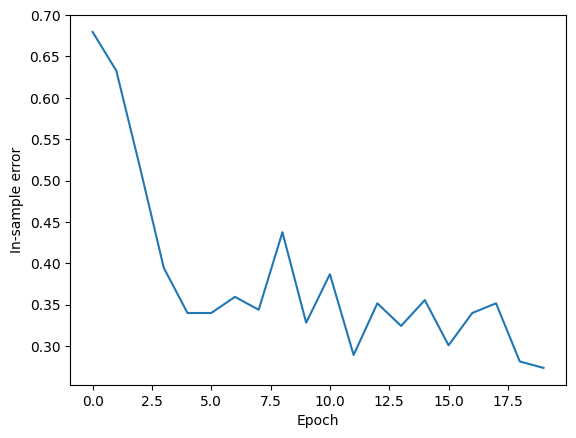

In [194]:
logit_training.eval.plot_error()

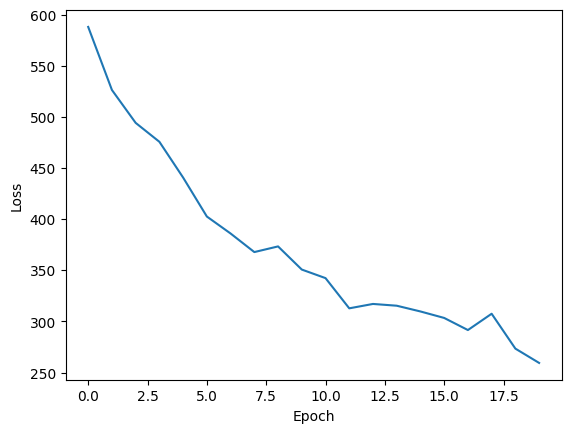

In [195]:
logit_training.eval.plot_loss()

In [196]:
logit_training.Test()

Out-of-sample error: tensor(0.3414)


In [45]:
'''--------------------------------------------------------'''

'--------------------------------------------------------'

In [46]:
#Perceptron initiation

MLP = nn.Sequential(nn.Flatten(),
                    nn.Linear(784,256),
                    nn.ReLU(),
                    nn.Linear(256,10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

MLP.apply(init_weights)

MLP_loss = nn.CrossEntropyLoss(reduction='none')

MLP_trainer = torch.optim.SGD(MLP.parameters(),lr = 0.1)

-------------------
1th epoch
Loss: 589.3129363431881
In-sample error: tensor(0.8906)
-------------------
2th epoch
Loss: 588.0891849827242
In-sample error: tensor(0.8750)
-------------------
3th epoch
Loss: 585.9497013066683
In-sample error: tensor(0.8828)
-------------------
4th epoch
Loss: 584.7267565624908
In-sample error: tensor(0.8398)
-------------------
5th epoch
Loss: 582.608947428761
In-sample error: tensor(0.7695)
-------------------
6th epoch
Loss: 581.0240010379774
In-sample error: tensor(0.7188)
-------------------
7th epoch
Loss: 578.2369153019553
In-sample error: tensor(0.6250)
-------------------
8th epoch
Loss: 577.438456147366
In-sample error: tensor(0.6562)
-------------------
9th epoch
Loss: 574.0975469987625
In-sample error: tensor(0.6953)
-------------------
10th epoch
Loss: 572.0746901134472
In-sample error: tensor(0.7070)
-------------------
11th epoch
Loss: 567.9180621537311
In-sample error: tensor(0.6602)
-------------------
12th epoch
Loss: 565.0213340587513

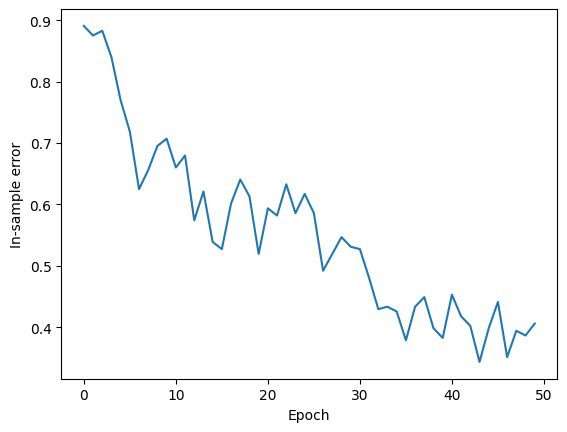

In [47]:
MLP_Training = Gradient_Img_Trainer(MLP, mnist_train_iter, MLP_loss, MLP_trainer, mnist_test_iter)
MLP_Training.Train(50)

In [48]:
MLP_Training.Test()

Out-of-sample error: tensor(0.4329)


In [49]:
'''--------------------------------------------------------'''

'--------------------------------------------------------'

In [50]:
#Running a logistic regression with weight decay

Wd_net = nn.Sequential(nn.Flatten(),
                    nn.Linear(784,10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

Wd_net.apply(init_weights)

Wd_loss = nn.CrossEntropyLoss(reduction='none')

Weight_decay = 10

Wd_trainer = torch.optim.SGD([
    {"params":Wd_net[1].weight,'weight decay':Weight_decay},
    {"params":Wd_net[1].bias}],lr = 0.1)

-------------------
1th epoch
Loss: 584.7893581153643
In-sample error: tensor(0.7305)
-------------------
2th epoch
Loss: 527.3086460813738
In-sample error: tensor(0.5156)
-------------------
3th epoch
Loss: 491.0728709725405
In-sample error: tensor(0.5547)
-------------------
4th epoch
Loss: 478.96862840886615
In-sample error: tensor(0.4531)
-------------------
5th epoch
Loss: 433.8595048331514
In-sample error: tensor(0.4062)
-------------------
6th epoch
Loss: 429.41618486659286
In-sample error: tensor(0.4258)
-------------------
7th epoch
Loss: 389.47406380225743
In-sample error: tensor(0.3594)
-------------------
8th epoch
Loss: 371.77592651903035
In-sample error: tensor(0.3594)
-------------------
9th epoch
Loss: 363.27021157943517
In-sample error: tensor(0.3555)
-------------------
10th epoch
Loss: 342.4757699856971
In-sample error: tensor(0.3359)
-------------------
11th epoch
Loss: 323.191480133262
In-sample error: tensor(0.3125)
-------------------
12th epoch
Loss: 316.4208293

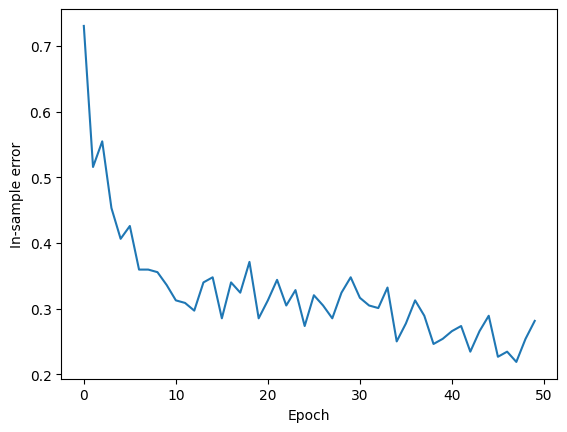

In [51]:
Wd_Training = Gradient_Img_Trainer(Wd_net, mnist_train_iter, Wd_loss, Wd_trainer, mnist_test_iter)
Wd_Training.Train(50)

In [52]:
Wd_Training.Test()

Out-of-sample error: tensor(0.2834)


In [ ]:
'''--------------------------------------------------------'''

In [11]:
#Multilayer Perceptron with Weight Decay and different parameters
WM_net = nn.Sequential(nn.Flatten(),
                        nn.Linear(784,256),
                        nn.Tanh(),
                        nn.Linear(256,10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

WM_net.apply(init_weights)

WM_loss = nn.CrossEntropyLoss(reduction='none')

Weight_decay = 3

WM_trainer = torch.optim.SGD([
    {"params":WM_net[1].weight,'weight decay':Weight_decay},
    {"params":WM_net[1].bias}],lr = 0.1)

-------------------
1th epoch
Loss: 588.6388504763185
In-sample error: tensor(0.8984)
-------------------
2th epoch
Loss: 588.3417362157631
In-sample error: tensor(0.9062)
-------------------
3th epoch
Loss: 586.4666796461147
In-sample error: tensor(0.8945)
-------------------
4th epoch
Loss: 584.5877790585814
In-sample error: tensor(0.8672)
-------------------
5th epoch
Loss: 583.5587523113289
In-sample error: tensor(0.9062)
-------------------
6th epoch
Loss: 581.5892844433909
In-sample error: tensor(0.8867)
-------------------
7th epoch
Loss: 579.4491876490555
In-sample error: tensor(0.8438)
-------------------
8th epoch
Loss: 577.909404808732
In-sample error: tensor(0.8320)
-------------------
9th epoch
Loss: 575.6379447563099
In-sample error: tensor(0.7812)
-------------------
10th epoch
Loss: 573.8933557157857
In-sample error: tensor(0.7148)
-------------------
11th epoch
Loss: 572.6310487044029
In-sample error: tensor(0.7109)
-------------------
12th epoch
Loss: 570.483462875814

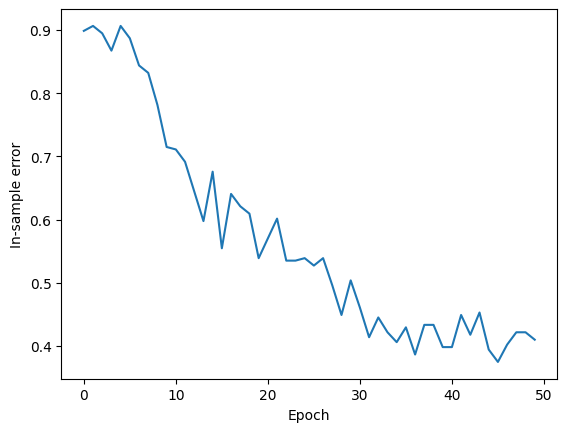

In [12]:
#Training MLP with weight decay
WM_Training = Gradient_Img_Trainer(WM_net,mnist_train_iter,WM_loss,WM_trainer,mnist_test_iter)
WM_Training.Train(50)

In [ ]:
'''--------------------------------------------------------'''

In [22]:
#MLP with Drop-out

Dropout_net = nn.Sequential(nn.Flatten(),
                            nn.Linear(784,256),
                            nn.ReLU(),
                            nn.Dropout(0.2),
                            nn.Linear(256,256),
                            nn.ReLU(0.5),
                            nn.Dropout(0.5),
                            nn.Linear(256,10)
                            )

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

Dropout_net.apply(init_weights)

Dropout_loss = nn.CrossEntropyLoss(reduction='none')
Dropout_trainer = torch.optim.SGD(Dropout_net.parameters(), lr = 0.5)

-------------------
1th epoch
Loss: 589.6979523499665
In-sample error: tensor(0.9062)
-------------------
2th epoch
Loss: 588.5107049106989
In-sample error: tensor(0.8633)
-------------------
3th epoch
Loss: 588.4913904371328
In-sample error: tensor(0.8711)
-------------------
4th epoch
Loss: 588.9923198880233
In-sample error: tensor(0.8906)
-------------------
5th epoch
Loss: 588.4681541625126
In-sample error: tensor(0.8594)
-------------------
6th epoch
Loss: 588.7656427691295
In-sample error: tensor(0.8867)
-------------------
7th epoch
Loss: 588.2890994559613
In-sample error: tensor(0.8867)
-------------------
8th epoch
Loss: 587.5615559943494
In-sample error: tensor(0.8398)
-------------------
9th epoch
Loss: 589.4670929245061
In-sample error: tensor(0.8867)
-------------------
10th epoch
Loss: 587.4385176212947
In-sample error: tensor(0.8984)
-------------------
11th epoch
Loss: 586.0677062558009
In-sample error: tensor(0.8789)
-------------------
12th epoch
Loss: 586.53205207896

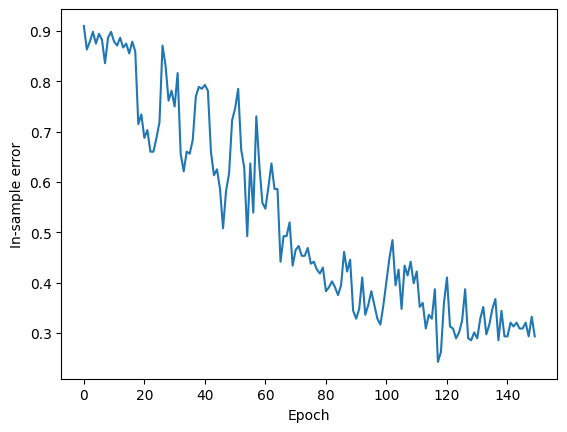

In [23]:
#Training with Drop-out
Dropout_training = Gradient_Img_Trainer(Dropout_net,mnist_train_iter,Dropout_loss,
                                        Dropout_trainer,mnist_test_iter)
Dropout_training.Train(150)

In [24]:
#Testing
Dropout_training.Test()

Out-of-sample error: tensor(0.2959)


In [ ]:
'''--------------------------------------------------------'''

In [32]:
#For our CNN implementation we'll be significantly increasing our batch sizes
mnist_batch_size = 1024

mnist_train_iter = torch.utils.data.DataLoader(mnist_train,mnist_batch_size,shuffle=True,num_workers=4)

In [34]:
#Basic CNN implementation
CNN = nn.Sequential(
    nn.Conv2d(1,6,kernel_size=5,padding=2),nn.ReLU(),
    nn.MaxPool2d(kernel_size=2,stride=2),
    nn.Conv2d(6,16,kernel_size=5), nn.ReLU(),
    nn.MaxPool2d(kernel_size=2,stride=2),
    nn.Flatten(),
    nn.Linear(16*5*5,120), nn.ReLU(),
    nn.Linear(120,84), nn.ReLU(),
    nn.Linear(84,10))

def xavier_init(m):
    if type(m)== nn.Linear:
        nn.init.xavier_uniform_(m.weight)

CNN.apply(xavier_init)


CNN_loss = nn.CrossEntropyLoss(reduction='none')

CNN_trainer = torch.optim.SGD(CNN.parameters(),lr = 0.3)

-------------------
1th epoch
In-sample error: tensor(0.8760)
-------------------
2th epoch
In-sample error: tensor(0.6973)
-------------------
3th epoch
In-sample error: tensor(0.6807)
-------------------
4th epoch
In-sample error: tensor(0.6777)
-------------------
5th epoch
In-sample error: tensor(0.7012)
-------------------
6th epoch
In-sample error: tensor(0.8066)
-------------------
7th epoch
In-sample error: tensor(0.9033)
-------------------
8th epoch
In-sample error: tensor(0.8291)
-------------------
9th epoch
In-sample error: tensor(0.8623)
-------------------
10th epoch
In-sample error: tensor(0.8213)
-------------------
11th epoch
In-sample error: tensor(0.7695)
-------------------
12th epoch
In-sample error: tensor(0.7734)
-------------------
13th epoch
In-sample error: tensor(0.7236)
-------------------
14th epoch
In-sample error: tensor(0.7451)
-------------------
15th epoch
In-sample error: tensor(0.7266)
-------------------
16th epoch
In-sample error: tensor(0.7080)
-

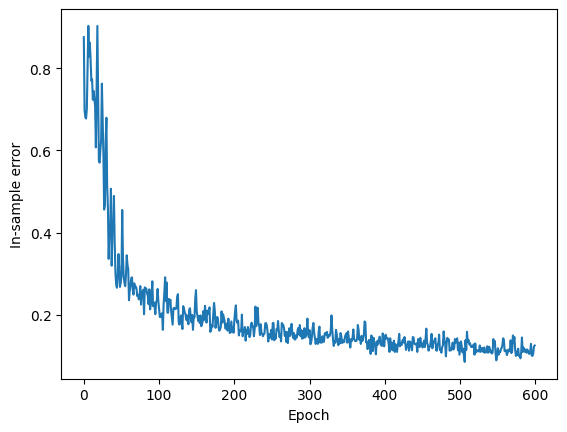

In [35]:
#Training of our CNN
CNN_training = Gradient_Img_Trainer(CNN,mnist_train_iter,CNN_loss,CNN_trainer,mnist_test_iter)
CNN_training.Train(600, print_loss=False)

In [37]:
#Testing our model (we'd normally use validation set here to avoid overfitting to test data)
CNN_training.Test()

Out-of-sample error: tensor(0.1476)


In [ ]:
'''--------------------------------------------------------'''

In [57]:
#Running a CNN with learning rate decay
CNN2 = nn.Sequential(
    nn.Conv2d(1,6,kernel_size=5,padding=2),nn.ReLU(),
    nn.MaxPool2d(kernel_size=2,stride=2),
    nn.Conv2d(6,16,kernel_size=5), nn.ReLU(),
    nn.MaxPool2d(kernel_size=2,stride=2),
    nn.Flatten(),
    nn.Linear(16*5*5,120), nn.ReLU(),nn.Dropout(0.2),
    nn.Linear(120,84), nn.ReLU(),nn.Dropout(0.2),
    nn.Linear(84,10))

def xavier_init(m):
    if type(m)== nn.Linear:
        nn.init.xavier_uniform_(m.weight)

CNN2.apply(xavier_init)


CNN2_loss = nn.CrossEntropyLoss(reduction='none')

CNN2_trainer = torch.optim.SGD(CNN2.parameters(),lr = 0.3)

CNN2_scheduler = torch.optim.lr_scheduler.MultiStepLR(CNN2_trainer,milestones=[50,100,200,400,600,700],gamma=0.8)

-------------------
1th epoch
In-sample error: tensor(0.8672)
-------------------
2th epoch
In-sample error: tensor(0.8174)
-------------------
3th epoch
In-sample error: tensor(0.8291)
-------------------
4th epoch
In-sample error: tensor(0.7500)
-------------------
5th epoch
In-sample error: tensor(0.8291)
-------------------
6th epoch
In-sample error: tensor(0.7734)
-------------------
7th epoch
In-sample error: tensor(0.6953)
-------------------
8th epoch
In-sample error: tensor(0.7188)
-------------------
9th epoch
In-sample error: tensor(0.8145)
-------------------
10th epoch
In-sample error: tensor(0.8447)
-------------------
11th epoch
In-sample error: tensor(0.6416)
-------------------
12th epoch
In-sample error: tensor(0.6211)
-------------------
13th epoch
In-sample error: tensor(0.7539)
-------------------
14th epoch
In-sample error: tensor(0.6904)
-------------------
15th epoch
In-sample error: tensor(0.6338)
-------------------
16th epoch
In-sample error: tensor(0.6504)
-

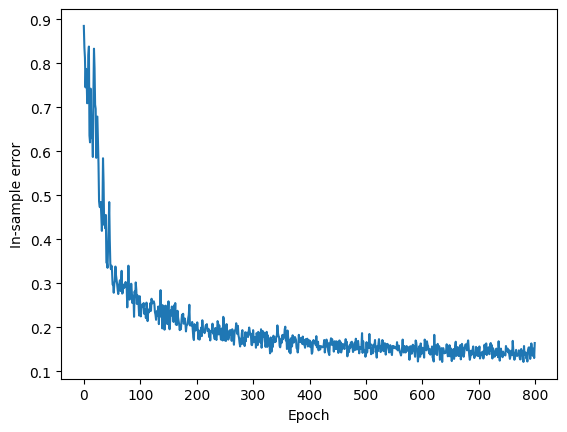

In [58]:
#Training our model with decaying learning rate scheduled at 50'th and 600'th epoch
CNN2_training = Gradient_Img_Trainer(CNN2,mnist_train_iter,CNN2_loss,CNN2_trainer,mnist_test_iter,CNN2_scheduler)
CNN2_training.Train(800, print_loss=False)

In [59]:
CNN2_training.Test()

Out-of-sample error: tensor(0.1396)


In [ ]:
'''--------------------------------------------------------'''

In [40]:
#Experimenting with convolutions and batch normalization
CNN3 = nn.Sequential(
    nn.Conv2d(1,16,kernel_size=5,padding=2),nn.BatchNorm2d(16),nn.ReLU(),
    nn.MaxPool2d(kernel_size=2,stride=2),
    nn.Conv2d(16,64,kernel_size=3,padding=1),nn.BatchNorm2d(64),nn.ReLU(),
    nn.Conv2d(64,64,kernel_size=3,padding=1),nn.BatchNorm2d(64),nn.ReLU(),
    nn.Conv2d(64,16,kernel_size=3,padding=1),nn.BatchNorm2d(16),nn.ReLU(),
    nn.MaxPool2d(kernel_size=2,stride=2),
    nn.Flatten(),
    nn.Linear(784,120),nn.BatchNorm1d(120), nn.ReLU(),
    nn.Linear(120,84),nn.BatchNorm1d(84),nn.ReLU(),
    nn.Linear(84,10))



X,Y = next(iter(mnist_train_iter))
for layer in CNN3:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

Conv2d output shape: 	 torch.Size([256, 16, 28, 28])
BatchNorm2d output shape: 	 torch.Size([256, 16, 28, 28])
ReLU output shape: 	 torch.Size([256, 16, 28, 28])
MaxPool2d output shape: 	 torch.Size([256, 16, 14, 14])
Conv2d output shape: 	 torch.Size([256, 64, 14, 14])
BatchNorm2d output shape: 	 torch.Size([256, 64, 14, 14])
ReLU output shape: 	 torch.Size([256, 64, 14, 14])
Conv2d output shape: 	 torch.Size([256, 64, 14, 14])
BatchNorm2d output shape: 	 torch.Size([256, 64, 14, 14])
ReLU output shape: 	 torch.Size([256, 64, 14, 14])
Conv2d output shape: 	 torch.Size([256, 16, 14, 14])
BatchNorm2d output shape: 	 torch.Size([256, 16, 14, 14])
ReLU output shape: 	 torch.Size([256, 16, 14, 14])
MaxPool2d output shape: 	 torch.Size([256, 16, 7, 7])
Flatten output shape: 	 torch.Size([256, 784])
Linear output shape: 	 torch.Size([256, 120])
BatchNorm1d output shape: 	 torch.Size([256, 120])
ReLU output shape: 	 torch.Size([256, 120])
Linear output shape: 	 torch.Size([256, 84])
BatchNorm

In [43]:
#Running a CNN with learning rate decay
def xavier_init(m):
    if type(m)== nn.Linear:
        nn.init.xavier_uniform_(m.weight)

CNN3.apply(xavier_init)


CNN3_loss = nn.CrossEntropyLoss(reduction='none')

CNN3_trainer = torch.optim.SGD(CNN3.parameters(),lr = 0.3)

CNN3_scheduler = torch.optim.lr_scheduler.MultiStepLR(CNN3_trainer,milestones=[50,100,200,400,600,700],gamma=0.8)

-------------------
1th epoch
In-sample error: tensor(0.3164)
-------------------
2th epoch
In-sample error: tensor(0.1680)
-------------------
3th epoch
In-sample error: tensor(0.1953)
-------------------
4th epoch
In-sample error: tensor(0.2148)
-------------------
5th epoch
In-sample error: tensor(0.1641)
-------------------
6th epoch
In-sample error: tensor(0.2422)
-------------------
7th epoch
In-sample error: tensor(0.2031)
-------------------
8th epoch
In-sample error: tensor(0.1641)
-------------------
9th epoch
In-sample error: tensor(0.1875)
-------------------
10th epoch
In-sample error: tensor(0.1172)
-------------------
11th epoch
In-sample error: tensor(0.1172)
-------------------
12th epoch
In-sample error: tensor(0.1445)
-------------------
13th epoch
In-sample error: tensor(0.1484)
-------------------
14th epoch
In-sample error: tensor(0.1484)
-------------------
15th epoch
In-sample error: tensor(0.1094)
-------------------
16th epoch
In-sample error: tensor(0.1211)
-

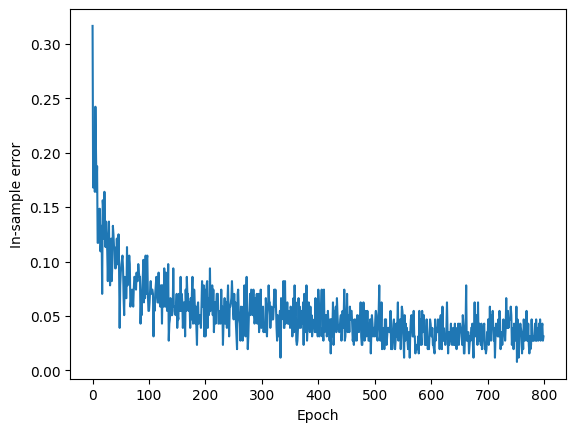

In [44]:
#Training the model
CNN3_training = Gradient_Img_Trainer(CNN3,mnist_train_iter,CNN3_loss,CNN3_trainer,mnist_test_iter,CNN3_scheduler)

CNN3_training.Train(800)

In [45]:
CNN3_training.Test()
#We're starting to see very satisfactory results

Out-of-sample error: tensor(0.0995)
